# Neural network from scratch

## Table of Contents
* [Visualizing and Preprocessing](#Visualizing-and-Preprocessing)
    * [Images](#Class-Images)
    * [Class frequencies](#Class-Frequencies)
    * [Normalization](#Normalization)
* [FeedForwardNN](#FeedForwardNN)
    * [Data loader](#DataLoader)
    * [Activation Functions](#Activation-Functions)
    * [Loss Functions](#Loss-Functions)
    * [Layer](#Layer)
    * [Feed Forward Neural Network](#Feed-Forward-Neural-Network)
* [Classification](#Classification)
    * [Learning Rate](#Learning-Rate)
        * [Learning Rate * 10](#Learning-rate-*-10:)
        * [Learning Rate * 0.1](#Learning-rate-*-0.1:)
    * [Other Activation Functions](#Other-Activation-Functions)
        * [Leaky Relu](#Leaky-Relu)
        * [Leaky Relu vs Relu](#Leaky-Relu-vs-Relu)
        * [Sigmoid](#Sigmoid)
        * [Tanh](#Tanh)
        * [Sigmoid and Tanh problem](#Sigmoid-and-Tanh-problem)
    * [Mini Batch Size](#Mini-Batch-Size)
        * [Batch Size = 16](#Batch-Size-=-16)
        * [Batch Size = 128](#Batch-Size-=-128)
    * [Epochs](#Epochs)
    * [Ovefitting](#Overfitting)
        * [Accuracy Plot](#Accuracy)
        * [Loss Plot](#Loss)
* [Visualizing in low dimension](#Visualizing-in-Low-Dimension)

In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trainData = pd.read_csv("trainData.csv", header=None)
trainLabels = pd.read_csv("trainLabels.csv", header=None)
testData = pd.read_csv("testData.csv", header=None)
testLabels = pd.read_csv("testLabels.csv", header=None)

## Visualizing and Preprocessing

### Class Images

In [3]:
import cv2
import IPython

for index, row in trainLabels.drop_duplicates(0).sort_values(by=0).iterrows():
    p = trainData.iloc[index, :].to_numpy().reshape(28,28)
    _, ret = cv2.imencode('.jpg', p) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    print("Class: ",  row[0])

Class:  0


Class:  1


Class:  2


Class:  3


Class:  4


Class:  5


Class:  6


Class:  7


Class:  8


Class:  9


### Class Frequencies

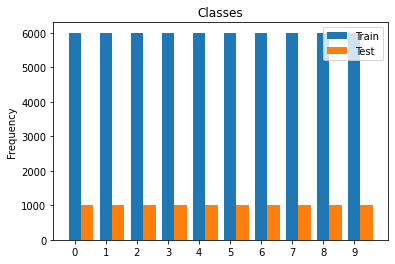

In [4]:
train = trainLabels.value_counts().sort_index()
test = testLabels.value_counts().sort_index()
N = 10
ind = np.arange(N)
width = 0.4
plt.bar(ind, train, width, label="Train")
plt.bar(ind + width, test, width, label="Test")

plt.ylabel("Frequency")
plt.title("Classes")

plt.xticks(np.arange(0, 10))
plt.legend(loc="best")
plt.show()

### Normalization
The goal in normalization is to change the values to a single scale.  
There are multiple benefits when normalizing data, one of them is that we don't let our gradients get out of control.  
For example the range of our data would differed greatly and it woul have lots of effect on our gradients.  
All in all it offen has a good effect on ourl model learning process.

In [5]:
trainData = trainData / 255
testData = testData / 255

## FeedForwardNN

### DataLoader

In [2]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = np.eye(n_classes)[labels]
        return onehot_vectors
    
    def __shuffle_dataset(self):
        p = np.random.permutation(len(self.__data))
        self.__data = self.__data[p]
        self.__onehot_labels = self.__onehot_labels[p]
    
    def __iter__(self):
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

### Activation Functions

In [3]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        relu_value = np.maximum(0, temp)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.matrix(matrix, dtype=float)
        relu_derivative[relu_derivative >= 0] = 1
        relu_derivative[relu_derivative < 0] = 0
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leaky_relu_value = np.matrix(matrix, dtype=float)
        leaky_relu_value = np.where(leaky_relu_value >= 0, leaky_relu_value, leaky_relu_value * self.negative_slope)
        return np.matrix(leaky_relu_value)

    def derivative(self, matrix):
        leaky_relu_derivative = np.matrix(matrix, dtype=float)
        leaky_relu_derivative[leaky_relu_derivative >= 0] = 1
        leaky_relu_derivative[leaky_relu_derivative < 0] = self.negative_slope
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:

    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = 1/(1 + np.exp(-temp))
        return sigmoid_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        return np.multiply(self.__val(temp), (1 - self.__val(temp)))

    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        def softmax(row):
            new = row - np.max(row)
            return np.exp(new)/np.sum(np.exp(new))            
        softmax_value = np.apply_along_axis(softmax, 1, temp)
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        tanh_value = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(tanh_value)
        return np.matrix(tanh_value)

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        temp = self.__val(temp)
        tanh_deravative = 1 - np.power(temp, 2)
        return tanh_deravative
    
    def __call__(self, matrix):
        return self.__val(matrix)

### Loss Functions

In [4]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, predicted_val, expected_val):
        assert np.shape(predicted_val)==np.shape(expected_val)
        temp_predicted_val = np.matrix(predicted_val, dtype=float)
        temp_expected_val = np.matrix(expected_val, dtype=float)
        softmax = Softmax()(temp_predicted_val)
        cross_entropy_value =  -1 * np.sum(np.multiply(expected_val, np.log(softmax)), axis=1)
        return cross_entropy_value
        
    def derivative(self, predicted_val, expected_val):
        assert np.shape(predicted_val)==np.shape(expected_val)
        temp_predicted_val = np.matrix(predicted_val, dtype=float)
        temp_expected_val = np.matrix(expected_val, dtype=float)
        softmax = Softmax()(temp_predicted_val)
        cross_entropy_derivative = softmax - temp_expected_val
        return cross_entropy_derivative
    
    def __call__(self, predicted_val, expected_val):
        return self.__val(predicted_val, expected_val)

### Layer
In general the learning process can be summarized feedforward and backpropagation steps.  
In the backpropagation phase we calculate the backprop tensor to pass to the previous layer and we update the weights and biases.  
Below we can see the equations to compute dl/dw and dl/dx.  
dl/dy is passed from the next layer to this layer and at first it comes from the loss function.  
__Bias__:  
Computing dl/db is the same as dl/dw but except X we will use a vector of size 1xbatch_size of ones.  
Because bias is not affected by our input.  
So we will multiply a vector like this by batch_size [1 1 1 1 1 1 1 1 1 1 1 1 1] into the dl/dy.

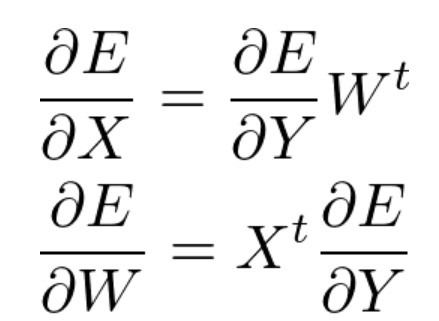

In [5]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        temp = np.matrix(layer_input, dtype=float)
        self.__last_input = temp
        self.__last_activation_input = np.matmul(temp, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        dl_dy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        identical = np.matrix(np.ones((np.size(backprop_tensor,0), 1)))
        dl_db = np.matmul(np.transpose(identical), dl_dy)
        dl_dw = np.matmul(np.transpose(self.__last_input), dl_dy)
        backprop_tensor = np.matmul(dl_dy, np.transpose(self.__weight))
        self.__weight = self.__weight - lr * dl_dw
        self.__bias = self.__bias - lr * dl_db
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.matrix(np.random.uniform(low, high, (dim1, dim2)))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.matrix(np.random.normal(mean, math.sqrt(var), (dim1, dim2)))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

### Feed Forward Neural Network

In [6]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None
        
        self.__train_before_last_out = []
        self.__test_before_last_out = []

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
        
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        forward = x_batch
        for layer in self.__layers_list:
            forward = layer.forward(forward)
            if layer.n_neurons == 2:
                self.__train_before_last_out.append((forward, y_batch))
        batch_accuracy = self.__compute_accuracy(forward, y_batch)
        losses = self.__loss(forward, y_batch)
        batch_average_loss = np.mean(losses)
        self.__update_weights(forward, y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        forward = x_batch
        for layer in self.__layers_list:
            forward = layer.forward(forward)
            if layer.n_neurons == 2:
                self.__test_before_last_out.append((forward, y_batch))
        batch_accuracy = self.__compute_accuracy(forward, y_batch)
        losses = self.__loss(forward, y_batch)
        batch_average_loss = np.mean(losses)
        return (batch_accuracy, batch_average_loss)

    
    def __compute_accuracy(self, output, expected_output):
        output_argmax = np.argmax(output, axis=1)
        expected_argmax = np.argmax(expected_output, axis=1)
        true_count = np.count_nonzero(output_argmax==expected_argmax)
        accuracy = true_count / np.size(output, 0)
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        backprop_tensor = self.__loss.derivative(output, y_train)
        for layer in reversed(self.__layers_list):
            backprop_tensor = layer.update_weights(backprop_tensor, self.__lr)
        return
    
    @property
    def train_before_last_out(self): return self.__train_before_last_out

    @property
    def test_before_last_out(self): return self.__test_before_last_out

## Classification

In [11]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=32, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=32, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6949666666666666	Average Loss: 0.844624150893564
	Test: Average Accuracy: 0.8042132587859425	Average Loss: 0.5696295762550753
Epoch 2:
	Train: Average Accuracy: 0.8237666666666666	Average Loss: 0.5062210031999231
	Test: Average Accuracy: 0.8257787539936102	Average Loss: 0.5041218945398634
Epoch 3:
	Train: Average Accuracy: 0.8375	Average Loss: 0.4641338287867471
	Test: Average Accuracy: 0.8338658146964856	Average Loss: 0.4789853075441909
Epoch 4:
	Train: Average Accuracy: 0.8458833333333333	Average Loss: 0.4412376107228059
	Test: Average Accuracy: 0.8383586261980831	Average Loss: 0.4641267859074932
Epoch 5:
	Train: Average Accuracy: 0.8516833333333333	Average Loss: 0.4247790787807531
	Test: Average Accuracy: 0.8431509584664537	Average Loss: 0.4514787519315018
Epoch 6:
	Train: Average Accuracy: 0.8553666666666667	Average Loss: 0.4117839042752102
	Test: Average Accuracy: 0.8463458466453674	Average Loss: 0.4450043478473531
Epoch 7:
	Train: Average Accu

### Learning Rate
Learning rate effects the learning process of a neural network.  
In general three different cases may happen.  
    1. Big learning rate  
    2. Small learning rate  
    3. Right learning rate  
In the big learning rate situation our model may diverge and never find the optimal weight and biases.  
In the small learning rate situation it may take a long time to converge and find the right solution.  
The right learning rate does not face the previous mentioned challenges.  
Below we can see two other learning rate specifications.

#### Learning rate * 10:
As we can see the neural network is stuck on 10% accuracy in this situation.  
The higher learning rate causes __gradient vanishing__ in Relu and it does not convege.

In [12]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.01
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=32, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=32, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.09916666666666667	Average Loss: 2.321196808364406
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.3059938727411686
Epoch 2:
	Train: Average Accuracy: 0.09938333333333334	Average Loss: 2.3049589950463365
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.3059938727411686
Epoch 3:
	Train: Average Accuracy: 0.09938333333333334	Average Loss: 2.3049589950463365
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.3059938727411686
Epoch 4:
	Train: Average Accuracy: 0.09938333333333334	Average Loss: 2.3049589950463365
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.3059938727411686
Epoch 5:
	Train: Average Accuracy: 0.09938333333333334	Average Loss: 2.3049589950463365
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.3059938727411686
Epoch 6:
	Train: Average Accuracy: 0.09938333333333334	Average Loss: 2.3049589950463365
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.3059938727411686
Epoch

#### Learning rate * 0.1:
As we can see, in this situation the learning process takes longer.  
And it takes more epochs to reach the same accuracy in the initial configuration.

In [13]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.0001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=32, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=32, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.3264666666666667	Average Loss: 1.8243412828750676
	Test: Average Accuracy: 0.5756789137380192	Average Loss: 1.2507553104103237
Epoch 2:
	Train: Average Accuracy: 0.6321333333333333	Average Loss: 1.0148190659318514
	Test: Average Accuracy: 0.6540535143769968	Average Loss: 0.8853983413399269
Epoch 3:
	Train: Average Accuracy: 0.6975	Average Loss: 0.8053352270765278
	Test: Average Accuracy: 0.6962859424920128	Average Loss: 0.7749683031650041
Epoch 4:
	Train: Average Accuracy: 0.73745	Average Loss: 0.7189503867554559
	Test: Average Accuracy: 0.7310303514376997	Average Loss: 0.70873606051301
Epoch 5:
	Train: Average Accuracy: 0.76315	Average Loss: 0.6608439061123466
	Test: Average Accuracy: 0.7623801916932907	Average Loss: 0.6600910199605643
Epoch 6:
	Train: Average Accuracy: 0.7853666666666667	Average Loss: 0.6172928043557591
	Test: Average Accuracy: 0.7796525559105432	Average Loss: 0.623099018302573
Epoch 7:
	Train: Average Accuracy: 0.8002333333333334

### Other Activation Functions

#### Leaky Relu
+ PROS:
    * Does not saturate
    * Computatiionaly effecient
    * Converges much faster
    * Will not kill gradients
- CONS:
    * Not always consistent

#### Leaky Relu vs Relu
    leaky relu has a slope for negative values instead of being zero.  
    it fixes the dying backprop problem in relu because the deravative does not becom zero in the minus parts.

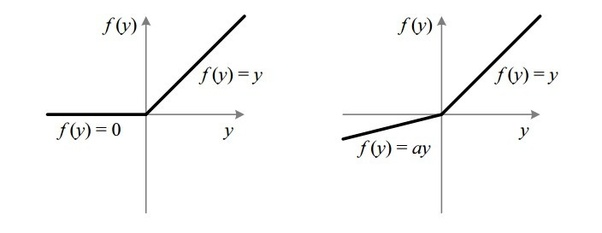


In [14]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=32, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=32, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6913666666666667	Average Loss: 0.8513909096294111
	Test: Average Accuracy: 0.8022164536741214	Average Loss: 0.5850625977509909
Epoch 2:
	Train: Average Accuracy: 0.8207666666666666	Average Loss: 0.5101738620774531
	Test: Average Accuracy: 0.8196884984025559	Average Loss: 0.5172078643597059
Epoch 3:
	Train: Average Accuracy: 0.83605	Average Loss: 0.46387676137632017
	Test: Average Accuracy: 0.8306709265175719	Average Loss: 0.48620967594390074
Epoch 4:
	Train: Average Accuracy: 0.8448166666666667	Average Loss: 0.4397527701157792
	Test: Average Accuracy: 0.8351637380191693	Average Loss: 0.46951630987847875
Epoch 5:
	Train: Average Accuracy: 0.8504333333333334	Average Loss: 0.4230734777827428
	Test: Average Accuracy: 0.8396565495207667	Average Loss: 0.4582978211093376
Epoch 6:
	Train: Average Accuracy: 0.8551833333333333	Average Loss: 0.4107011924072119
	Test: Average Accuracy: 0.84185303514377	Average Loss: 0.4522148142184504
Epoch 7:
	Train: Average A

#### Sigmoid
+ PROS:
    * Squashes numbers to [0,1]
- CONS:
    * When x is much positive or much negative it saturates and becomes zero
    * it's more computationally expensive in comparison to some other activations

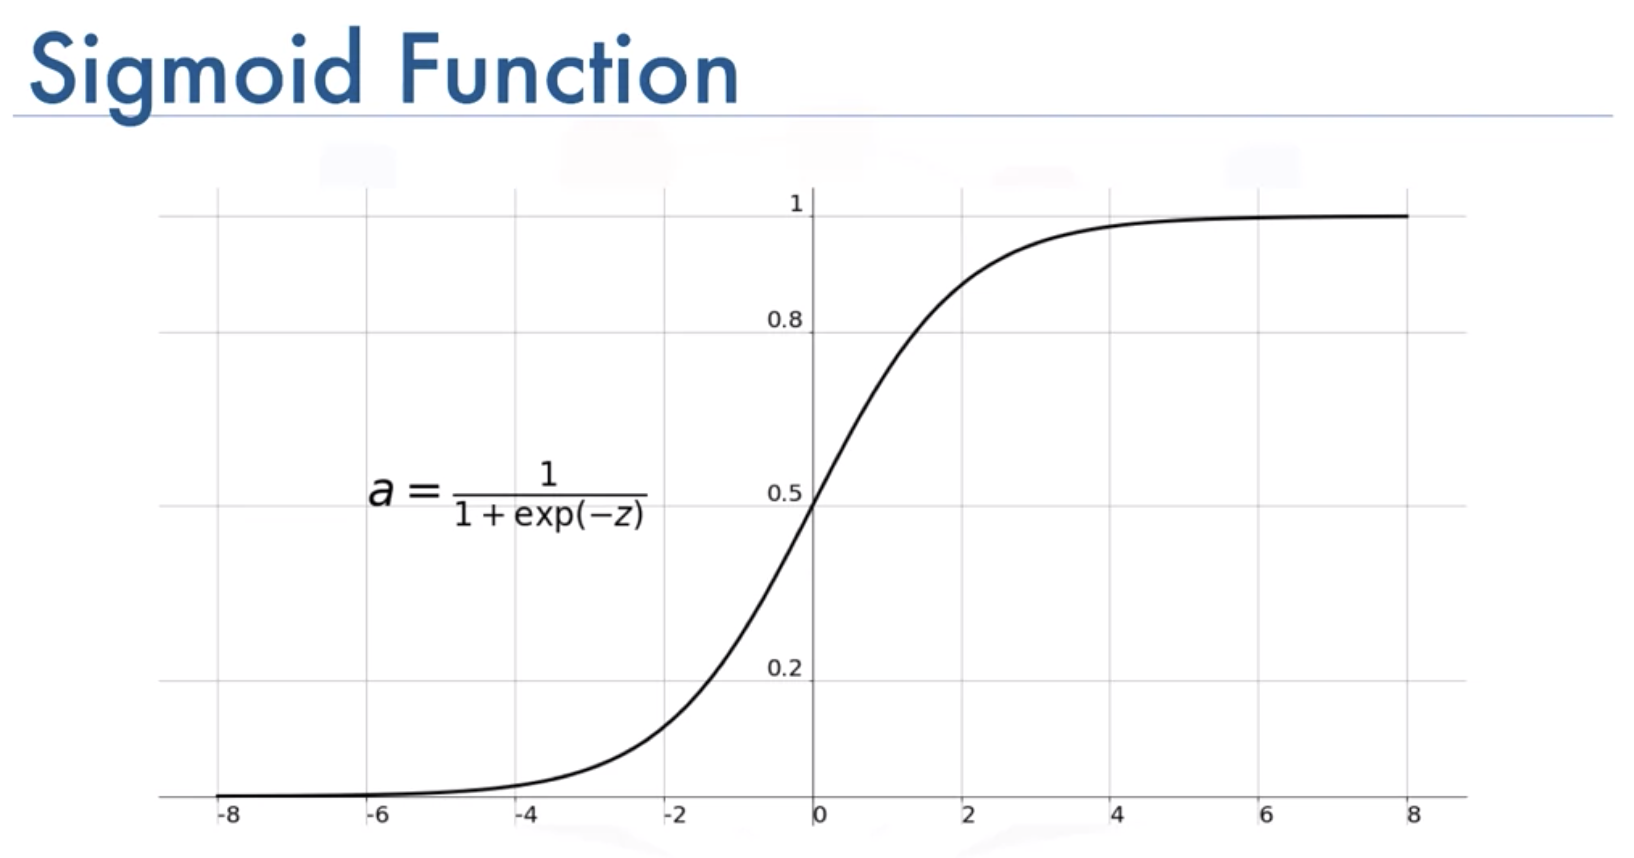

In [15]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=32, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=32, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(10, activation=Sigmoid(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.09883333333333333	Average Loss: 2.3023273563005313
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.302037580320117
Epoch 2:
	Train: Average Accuracy: 0.09911666666666667	Average Loss: 2.3018203956907852
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.301329198561698
Epoch 3:
	Train: Average Accuracy: 0.09871666666666666	Average Loss: 2.3001421746914605
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.296776966507227
Epoch 4:
	Train: Average Accuracy: 0.18265	Average Loss: 2.2673792277845863
	Test: Average Accuracy: 0.20646964856230032	Average Loss: 2.2222368605736933
Epoch 5:
	Train: Average Accuracy: 0.2345	Average Loss: 2.16819664043288
	Test: Average Accuracy: 0.2507987220447284	Average Loss: 2.1197213114223667
Epoch 6:
	Train: Average Accuracy: 0.2742	Average Loss: 2.0832569377970134
	Test: Average Accuracy: 0.23751996805111822	Average Loss: 2.053036757782472
Epoch 7:
	Train: Average Accuracy: 0.278433333333

#### Tanh
+ PROS:
    * Squashes numbers to range [-1,1]
    * zero centered
- CONS:
    * Kills the gradient for much positive or negative values

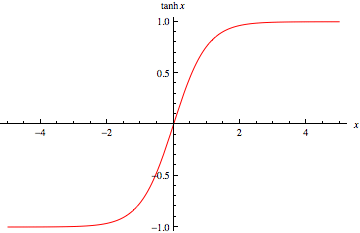

In [16]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=32, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=32, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=Tanh(), weight_initializer='uniform')
network.add_layer(10, activation=Tanh(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.10453333333333334	Average Loss: 2.3030768187919795
	Test: Average Accuracy: 0.15874600638977635	Average Loss: 2.2638473871549043
Epoch 2:
	Train: Average Accuracy: 0.24805	Average Loss: 1.8525655685940488
	Test: Average Accuracy: 0.26916932907348246	Average Loss: 1.7036080455857217
Epoch 3:
	Train: Average Accuracy: 0.2829333333333333	Average Loss: 1.6693046648364567
	Test: Average Accuracy: 0.33017172523961663	Average Loss: 1.6404087396446525
Epoch 4:
	Train: Average Accuracy: 0.43875	Average Loss: 1.501868447658235
	Test: Average Accuracy: 0.5428314696485623	Average Loss: 1.342493563366252
Epoch 5:
	Train: Average Accuracy: 0.56005	Average Loss: 1.2864940109203733
	Test: Average Accuracy: 0.5688897763578274	Average Loss: 1.2669655087630063
Epoch 6:
	Train: Average Accuracy: 0.5805	Average Loss: 1.2459836267038065
	Test: Average Accuracy: 0.5878594249201278	Average Loss: 1.2465054195841694
Epoch 7:
	Train: Average Accuracy: 0.5992666666666666	Avera

#### Sigmoid and Tanh problem
Sigmoid and Tanh don't have good performance because they saturate.  
For big negative and positive values they saturate and the deravative becomes zero.  
So the Learning process does not continue to improve.

### Mini Batch Size
In general there are three different ways to feed our neural network. __stochastic, minibatch and batch.__  
stochastic gets one data at a time, minibatch gets some data at each feed forward and the batch method gets all data at once.  
Stochastic requires less memory and its faster but it may fail in non convex neural networks because it may get stuck in the local minima.  
Minibatch also gets less memory than the batch method but its seen in practice that it causes better accuracy in comparison to the batch method.  
Batch method gets lots of memory and may get less accuracy and it may not be able to generalize well.  
__The problem with really small batch size:__  
It may cause lots of noise in the learning process and not finding the global optimal solution.  
For example stochastic gradient descent is known for not finding the global minima.  
Somehow sometimes the neural network can't learn well
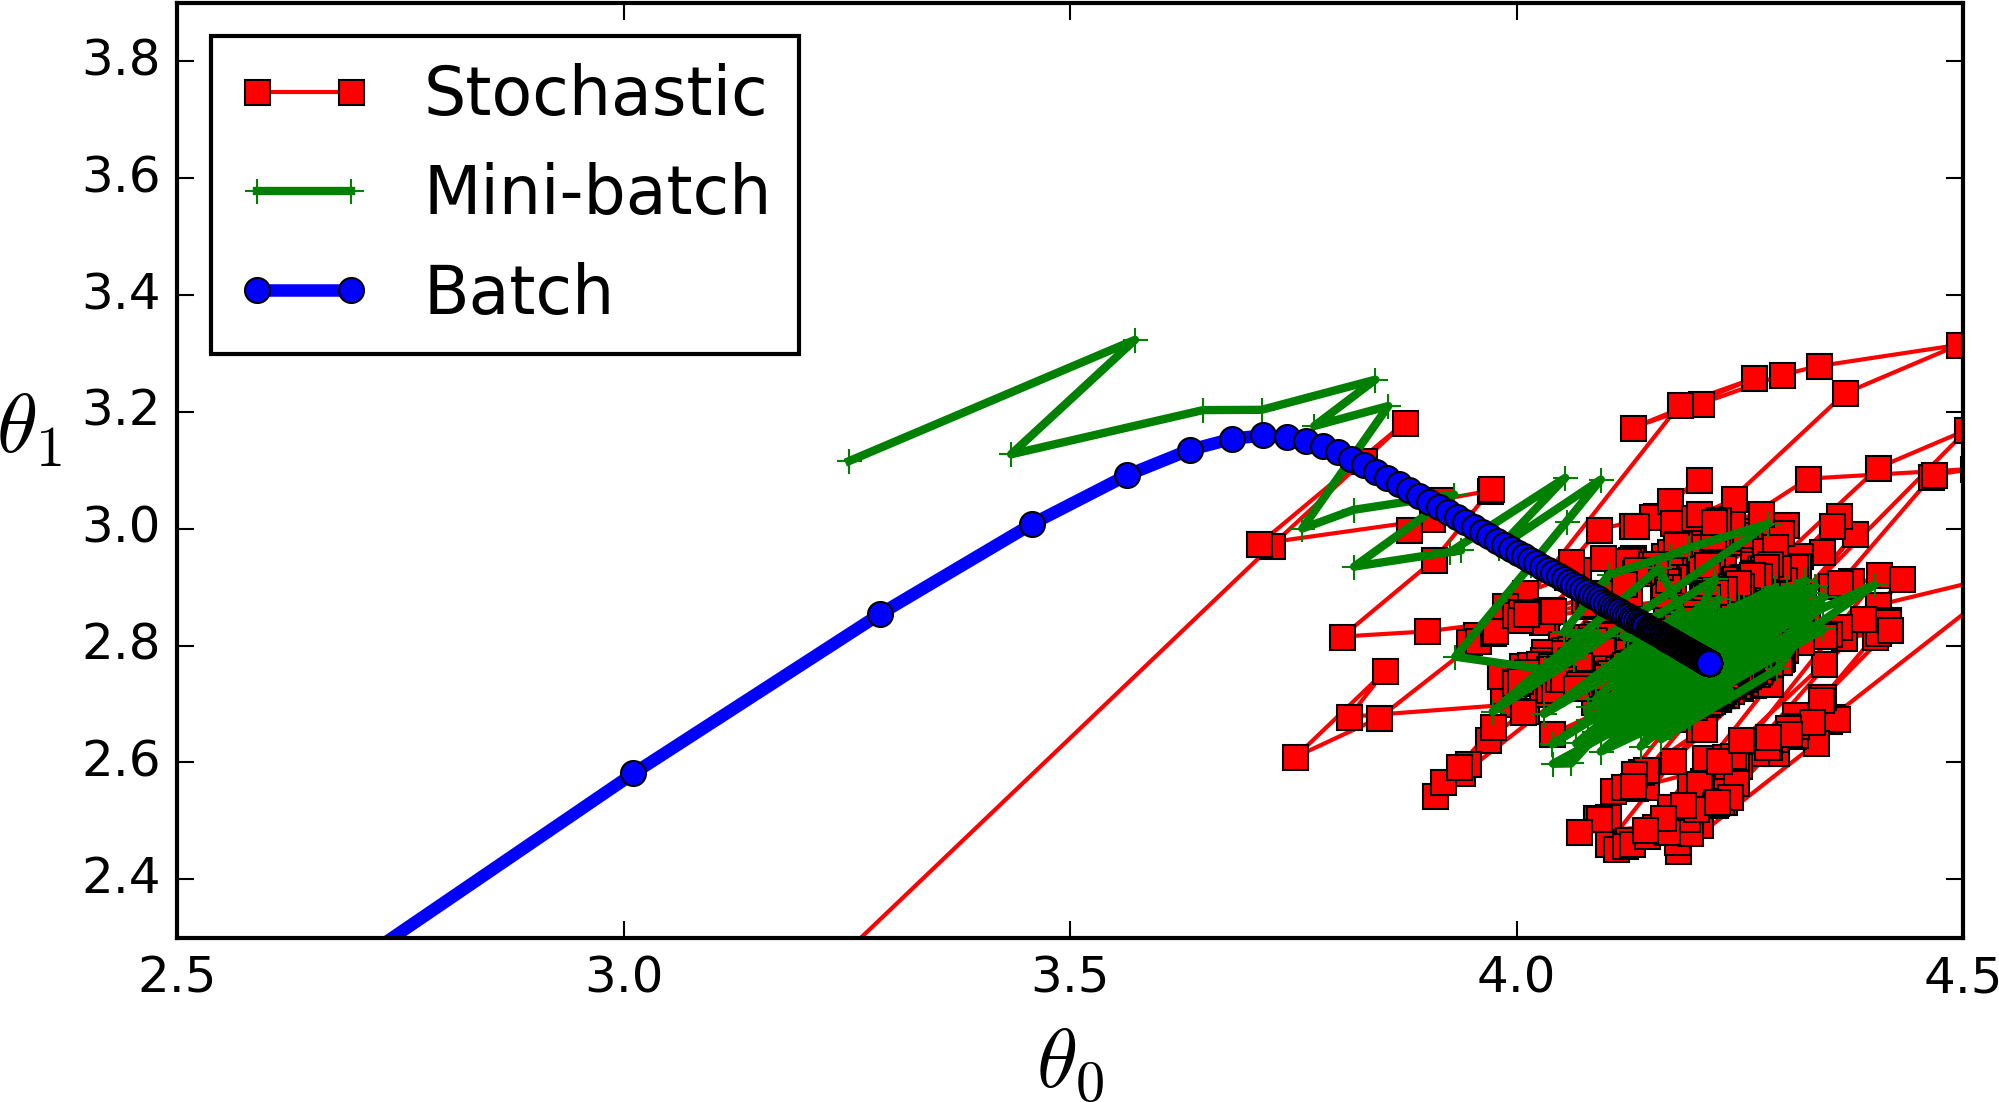

#### Batch Size = 16
It takes less than the batch size = 128 situation.  
And it usually generalizes bettter and has a better accuracy.

In [17]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=16, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=16, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6887666666666666	Average Loss: 0.8462126876545468
	Test: Average Accuracy: 0.7928	Average Loss: 0.5847974959361477
Epoch 2:
	Train: Average Accuracy: 0.8240333333333333	Average Loss: 0.5063875675193356
	Test: Average Accuracy: 0.8163	Average Loss: 0.5229303072580602
Epoch 3:
	Train: Average Accuracy: 0.8396	Average Loss: 0.4604487285747014
	Test: Average Accuracy: 0.8254	Average Loss: 0.4929773212021382
Epoch 4:
	Train: Average Accuracy: 0.8482333333333333	Average Loss: 0.4372333532724777
	Test: Average Accuracy: 0.833	Average Loss: 0.4752943203942255
Epoch 5:
	Train: Average Accuracy: 0.8532	Average Loss: 0.42208784260443477
	Test: Average Accuracy: 0.838	Average Loss: 0.46350057113591747
Epoch 6:
	Train: Average Accuracy: 0.8577666666666667	Average Loss: 0.4104856275595962
	Test: Average Accuracy: 0.8372	Average Loss: 0.4598870824255484
Epoch 7:
	Train: Average Accuracy: 0.8605833333333334	Average Loss: 0.40109765892178667
	Test: Average Accuracy:

#### Batch Size = 128
It takes more memory and it usually has less generalization than the smaller batch method.  
There is a tweet by Yann LeCun the FaceBook AI guy on this choice.  

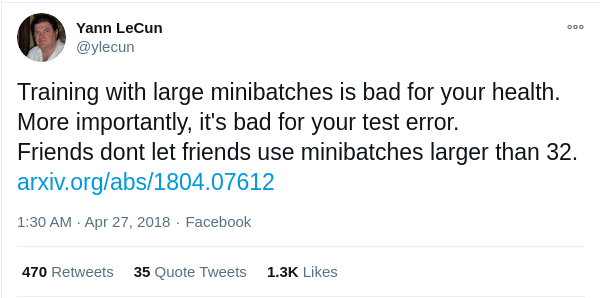

In [18]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=128, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=128, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6665889303482586	Average Loss: 1.0085259051378546
	Test: Average Accuracy: 0.7926226265822784	Average Loss: 0.6083346607396735
Epoch 2:
	Train: Average Accuracy: 0.8078635838663824	Average Loss: 0.5650617558347819
	Test: Average Accuracy: 0.8215981012658228	Average Loss: 0.5200791680533401
Epoch 3:
	Train: Average Accuracy: 0.826342617270789	Average Loss: 0.5040869664245293
	Test: Average Accuracy: 0.8316851265822784	Average Loss: 0.4879393952516559
Epoch 4:
	Train: Average Accuracy: 0.8370646766169154	Average Loss: 0.4720339414786829
	Test: Average Accuracy: 0.8361352848101266	Average Loss: 0.4699378809859069
Epoch 5:
	Train: Average Accuracy: 0.84375	Average Loss: 0.45151386563292595
	Test: Average Accuracy: 0.8400909810126582	Average Loss: 0.45737061486764496
Epoch 6:
	Train: Average Accuracy: 0.8485030206112296	Average Loss: 0.435540990925788
	Test: Average Accuracy: 0.8439477848101266	Average Loss: 0.4471630314967424
Epoch 7:
	Train: Average Ac

### Epochs
each Epoch is the process of feeding all data to the neural network for once.  
It means that the nural network sees each data once in one epoch.  
__Why we need multiple epochs:__  
Commonly one epoch is not enough to find the minima in out optimization problem.  
So we use multiple epochs to change the weights and biases to reach the optimal solution.  

### Overfitting
Ovefitting means not generalizing well and just doing good on the training set and not on the validation set.  
We train our neural network until the accuracy starts to decrease, this process is known as __early stopping__.  
In the following Accuracy and Loss plots we can see this phenomena.  
As we can see after an epoch the accuracy starts to drop on test set and the loss starts to go up on the test set.  
This means that we are starting to overfit on the training set and not generalizing well.

In [19]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 200
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=16, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=16, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(15, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6980166666666666	Average Loss: 0.8320961010321966
	Test: Average Accuracy: 0.8033	Average Loss: 0.5703834901620017
Epoch 2:
	Train: Average Accuracy: 0.8243166666666667	Average Loss: 0.5055488444112315
	Test: Average Accuracy: 0.8238	Average Loss: 0.5110812013180531
Epoch 3:
	Train: Average Accuracy: 0.8378833333333333	Average Loss: 0.46485342736120616
	Test: Average Accuracy: 0.8316	Average Loss: 0.4868593335077485
Epoch 4:
	Train: Average Accuracy: 0.8453833333333334	Average Loss: 0.44323246816608475
	Test: Average Accuracy: 0.8361	Average Loss: 0.4713924452877619
Epoch 5:
	Train: Average Accuracy: 0.85215	Average Loss: 0.4253030751200222
	Test: Average Accuracy: 0.8405	Average Loss: 0.45494642777697164
Epoch 6:
	Train: Average Accuracy: 0.8573166666666666	Average Loss: 0.40999597965171947
	Test: Average Accuracy: 0.8434	Average Loss: 0.44283329434474933
Epoch 7:
	Train: Average Accuracy: 0.86135	Average Loss: 0.39830879139819564
	Test: Average Ac

#### Accuracy

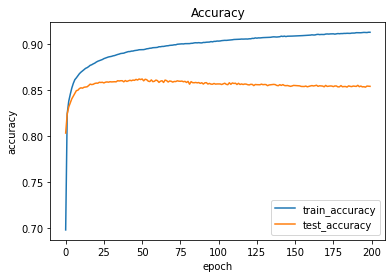

In [20]:
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(log["train_accuracy"], label="train_accuracy")
plt.plot(log["test_accuracy"], label="test_accuracy")
plt.legend(loc="best")
plt.show()

#### Loss

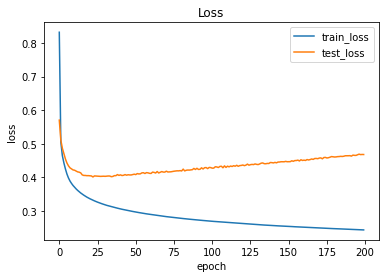

In [21]:
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(log["train_loss"], label="train_loss")
plt.plot(log["test_loss"], label="test_loss")
plt.legend(loc="best")
plt.show()

## Visualizing in Low Dimension
As we can see in the following plots the neural network was successfult to distinguish most classes from each other.  
But The class __6__ and __0__ are not completely away and they are overlapping.  
And with common sense its really logical because these two classes are both __shirts__ but different types.  
And its reasonable to not understand them well.

In [22]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30
TRAINLOADER = [batch for batch in Dataloader(trainData.to_numpy(), trainLabels.to_numpy(), 10, batch_size=16, shuffle=True)]
TESTLOADER = [batch for batch in Dataloader(testData.to_numpy(), testLabels.to_numpy(), 10, batch_size=16, shuffle=True)]

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(32, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(16, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.22666666666666666	Average Loss: 1.9768554177040196
	Test: Average Accuracy: 0.3964	Average Loss: 1.508512977185574
Epoch 2:
	Train: Average Accuracy: 0.43946666666666667	Average Loss: 1.4109633117791653
	Test: Average Accuracy: 0.5394	Average Loss: 1.196109874481592
Epoch 3:
	Train: Average Accuracy: 0.5745	Average Loss: 1.1135611226816227
	Test: Average Accuracy: 0.6496	Average Loss: 1.013244450988793
Epoch 4:
	Train: Average Accuracy: 0.66245	Average Loss: 0.9496609837655243
	Test: Average Accuracy: 0.6804	Average Loss: 0.8998981401625699
Epoch 5:
	Train: Average Accuracy: 0.6915333333333333	Average Loss: 0.8436941243302959
	Test: Average Accuracy: 0.6935	Average Loss: 0.8183888435386916
Epoch 6:
	Train: Average Accuracy: 0.72145	Average Loss: 0.7747853029607077
	Test: Average Accuracy: 0.7356	Average Loss: 0.7522581690862707
Epoch 7:
	Train: Average Accuracy: 0.7683666666666666	Average Loss: 0.7003277121149222
	Test: Average Accuracy: 0.7818	Aver

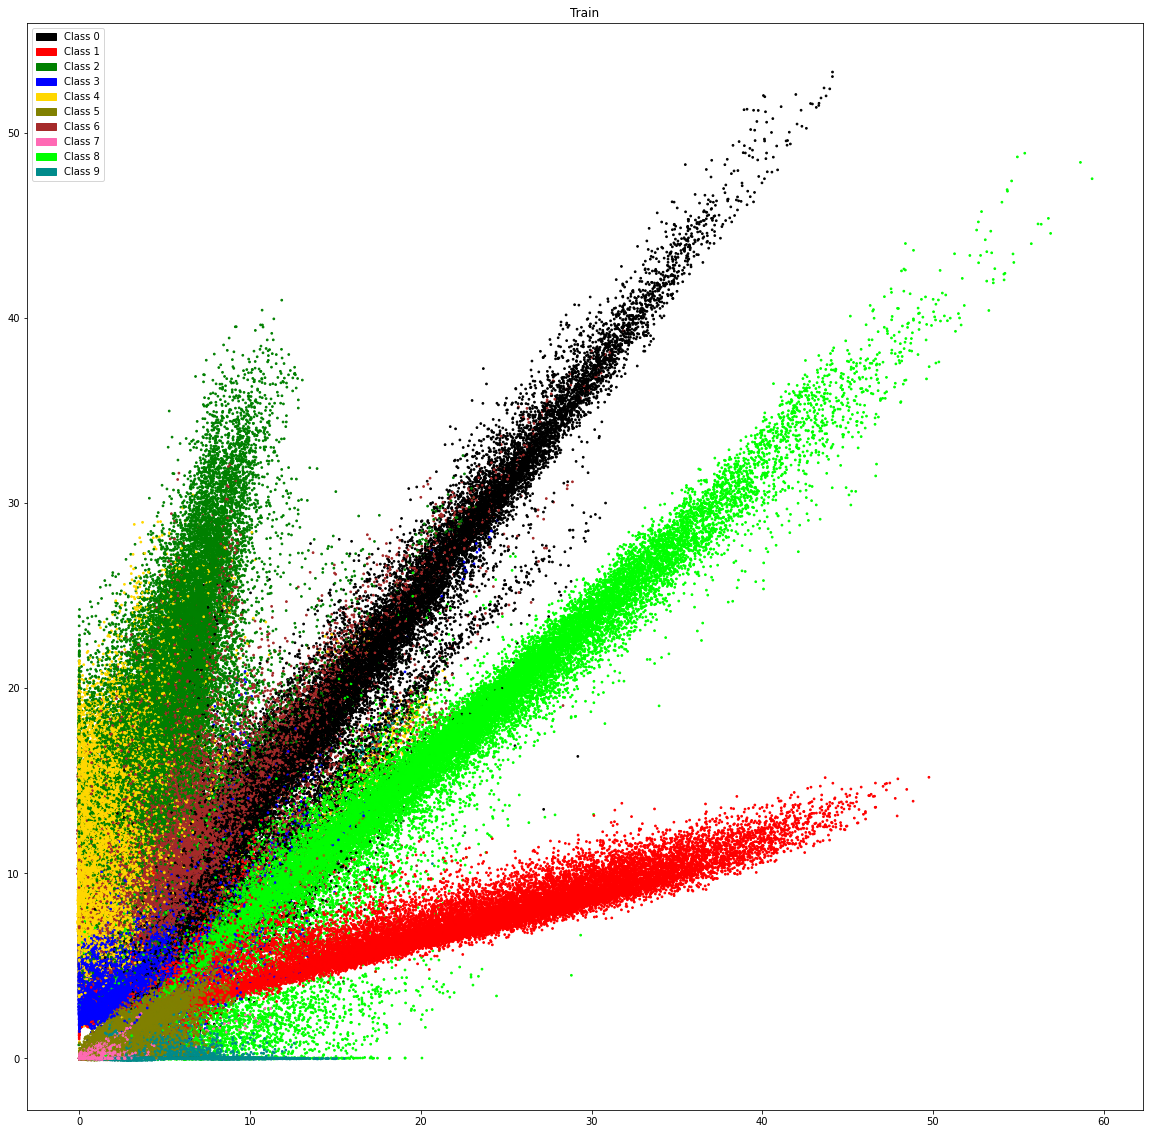

In [27]:
train_data_x = []
train_data_y = []
train_labels = []
for el in network.test_before_last_out:
    for x_y in el[0]:
        train_data_x.append(x_y.tolist()[0][0])
        train_data_y.append(x_y.tolist()[0][1])
    for label_map in el[1]:
        train_labels.append(np.argmax(label_map))
test_data_x = []
test_data_y = []
test_labels = []
for el in network.test_before_last_out:
    for x_y in el[0]:
        test_data_x.append(x_y.tolist()[0][0])
        test_data_y.append(x_y.tolist()[0][1])
    for label_map in el[1]:
        test_labels.append(np.argmax(label_map))
plt.figure(figsize=(20,20))
plt.title("Train")
colormap = np.array(["black", "red", "green", "blue", "gold", "olive", "brown", "hotpink", "lime", "darkcyan"])
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.scatter(train_data_x, train_data_y, c=colormap[train_labels], s=3)
import matplotlib.patches as mpatches
patches = []
for idx in categories:
    patches.append(mpatches.Patch(color=colormap[idx], label="Class " + str(idx)))
plt.legend(handles=patches)


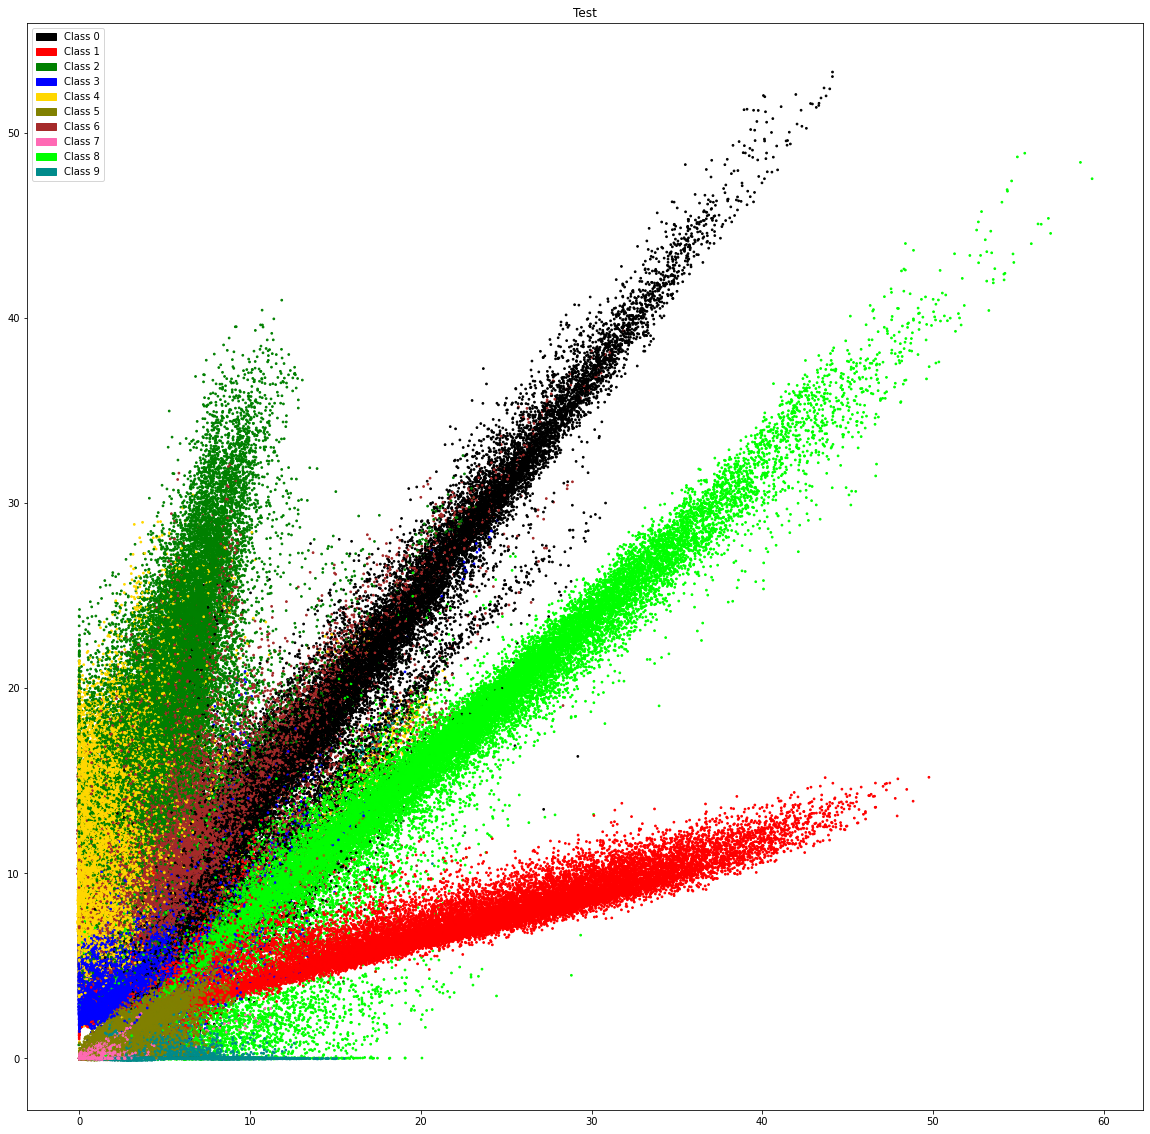

In [28]:
plt.figure(figsize=(20,20))
plt.title("Test")
colormap = np.array(["black", "red", "green", "blue", "gold", "olive", "brown", "hotpink", "lime", "darkcyan"])
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.scatter(test_data_x, test_data_y, c=colormap[train_labels], s=3)
import matplotlib.patches as mpatches
patches = []
for idx in categories:
    patches.append(mpatches.Patch(color=colormap[idx], label="Class " + str(idx)))
plt.legend(handles=patches)